In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

In [2]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [3]:
pokemon = pd.read_csv("pokemon.csv") # Dataset pokemon stats
combats = pd.read_csv("combats.csv") # Datas:qXet pokemon battles and who won

pokemon["Type 2"] = pokemon["Type 2"].fillna("NA")
pokemon.head()


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False


In [4]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

# Data preprocessing

## First approach processing

We wanted to make some comparisons according to our beliefs of what is more impactfull in the outcome of a pokemon battle and for that we need a base comparison, we guided this first approach to an approach seen in [here](https://github.com/kartikeya-rana/pokemon_battle/blob/master/Pokemon.ipynb), in this approach the individual opted to create a new data set that consisted of pokemon 1 stats followed by pokemon 2 statistics and finnaly the winner of the battle, 1 in case the first pokemon wins 0 otherwise, for simplicity purposes it is not possible to have a match with no winner.

## Second approach processing

After that we thought about instead of concatenating both pokemons statistics we wanted to make a subtraction of the first pokemon with the second and compare the new results with the first ones, we also eliminated both the generation and the Legendary information, as well as the type information, since that we know that pokemons of different generation have the same overall raw power, and we also know that pokemon that are legendary do not have big boosts in their stats, and they do not win against every non legendary pokemon

## Third approach processing

This last approach had in account our knowledge of the domain, we believe that pokemons with higher speed and higher attack are more prone to win, therefore we extracted those values and included them in a new dataset.

In [5]:
data_one_hot_encoding = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner

    x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
    y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
    #diff = (x-y)[:6] # difference between "base stats hp...."
    z = np.concatenate((x,y)) 
    if winner == first_pokemon:
        z = np.append(z, [0])
    else:
        z = np.append(z, [1])
        
        
    data_one_hot_encoding.append(z)
    if i > 5000:
        break
    
data_one_hot_encoding = np.asarray(data_one_hot_encoding)


In [6]:
data_diff_base_stats = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner
    
    x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
    y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
    diff = (x[2:9]-y[2:9]) # difference between "base stats hp...."
    
    z = []
    z = np.append(diff,z,0)
    

    if winner == first_pokemon:
        z = np.append(z, [0])
    else:
        z = np.append(z, [1])
        
    data_diff_base_stats.append(z)
    if i > 5000:
        break
    
data_diff_base_stats = np.asarray(data_diff_base_stats)
data_diff_base_stats = data_diff_base_stats[:, :-1].astype(int)

print(data_diff_base_stats[0])
print(pokemon.columns)

[-20  -6  10 -15  10 -19  -1]
Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')


In [7]:
pokemon_with_types = pokemon.copy()
types_list = [x for x in pokemon["Type 2"].unique()] + [x for x in pokemon["Type 1"].unique()]

types_list = list(set(types_list))

print(types_list.remove("NA"))
# make NA -> 0
types_list = ["NA"] + types_list

types_map = { x : types_list.index(x) for x in types_list}

pokemon_with_types["Type 1"] = pokemon_with_types["Type 1"].map(types_map)
pokemon_with_types["Type 2"] = pokemon_with_types["Type 2"].map(types_map)

pokemon.head()

print(types_map)
print(types_list)

None
{'NA': 0, 'Fighting': 1, 'Ground': 2, 'Dragon': 3, 'Poison': 4, 'Steel': 5, 'Grass': 6, 'Rock': 7, 'Water': 8, 'Fire': 9, 'Electric': 10, 'Flying': 11, 'Ghost': 12, 'Dark': 13, 'Psychic': 14, 'Normal': 15, 'Fairy': 16, 'Bug': 17, 'Ice': 18}
['NA', 'Fighting', 'Ground', 'Dragon', 'Poison', 'Steel', 'Grass', 'Rock', 'Water', 'Fire', 'Electric', 'Flying', 'Ghost', 'Dark', 'Psychic', 'Normal', 'Fairy', 'Bug', 'Ice']


In [8]:
data_with_types = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner

    x = pokemon_with_types.loc[pokemon["#"]==first_pokemon]
    x = x.drop(columns=["Name","#"]).values[0]
    y = pokemon_with_types.loc[pokemon["#"]==second_pokemon].drop(columns=["Name","#"]).values[0]
    
    
    z = np.concatenate((x,y)) 
    
    if winner == first_pokemon:
        z = np.append(z, [0])
    else:
        z = np.append(z, [1])
        
    data_with_types.append(z)
    if i > 5000:
        break
    
data_with_types = np.asarray(data_with_types)
data_with_types= pd.DataFrame(data_with_types, columns=[
       'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary' ,
       'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary','Win'] )

data_with_types = data_with_types.astype({
       'Type 1':'int32', 'Type 2':'int32', 'HP':'int32', 'Attack':'int32', 'Defense':'int32', 'Sp. Atk':'int32',
       'Sp. Def':'int32', 'Speed':'int32', 'Generation':'int32', 'Legendary':'int32' ,
       'Type 1':'int32', 'Type 2':'int32', 'HP':'int32', 'Attack':'int32', 'Defense':'int32', 'Sp. Atk':'int32',
       'Sp. Def':'int32', 'Speed':'int32', 'Generation':'int32', 'Legendary':'int32','Win':'int32' })


X_imp_feat = data_with_types[['Type 1', 'Type 2','Attack', 'Speed']]

y = data_with_types["Win"]

print(y)




0       1
1       1
2       1
3       1
4       0
       ..
4996    0
4997    1
4998    1
4999    0
5000    1
Name: Win, Length: 5001, dtype: int32


In [9]:
data_with_types.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,...,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Win
0,7,2,50,64,50,45,50,41,2,0,...,13,70,70,40,60,40,60,3,0,1
1,6,1,91,90,72,90,129,108,5,1,...,1,91,129,90,72,90,108,5,1,1
2,16,11,55,40,85,80,105,40,2,0,...,0,75,75,75,125,95,40,5,0,1
3,9,0,40,40,40,70,40,20,2,0,...,0,77,120,90,60,90,48,5,0,1
4,7,8,70,60,125,115,70,55,1,0,...,7,20,10,230,10,230,5,2,0,0


### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

In [10]:
unique_ids=pokemon['#']
wins_by_id = []
for _id in unique_ids:
    wins_by_id.append([_id ,(combats["Winner"] == _id).sum() ])
    
wins_by_id = np.asarray(wins_by_id)

pokemon["Wins"] = wins_by_id[:,1]
pokemon["Legendary"] = pokemon["Legendary"].astype(int)




<AxesSubplot:>

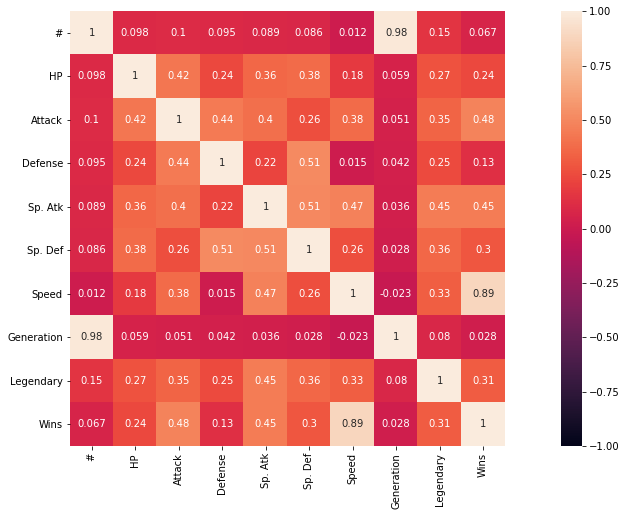

In [11]:

plt.figure(figsize=(20,8))
sns.heatmap(pokemon.corr(),square=True, vmin=-1, vmax=1, annot=True)

### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

# Graph that shows the correlation between number of wins and speed

Overall the speed of the pokemon is more impactfull in the outcome of battle than most of the other attributes.

<AxesSubplot:xlabel='Attack'>

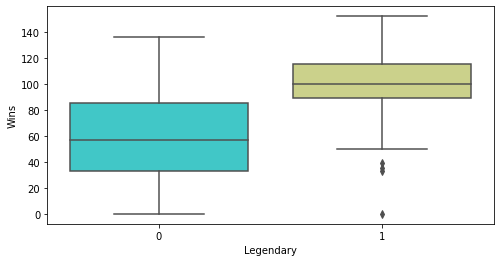

<Figure size 1440x576 with 0 Axes>

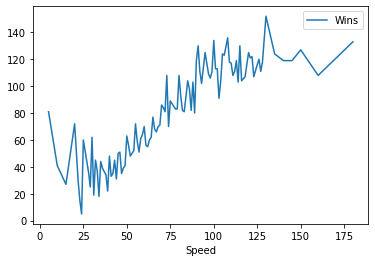

<Figure size 1440x576 with 0 Axes>

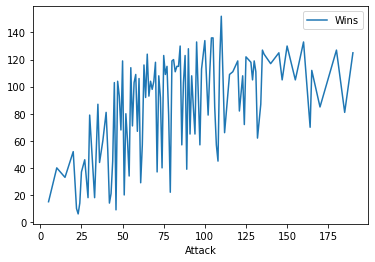

In [12]:
#boxplot of Attack vs. Legendary
plt.figure(figsize=(8, 4))
sns.boxplot(x='Legendary',y='Wins',data=pokemon, palette='rainbow')

#stripplot of speed Wins relation
plt.figure(figsize=(20,8))
speed_wins = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
speed_wins.sort_values(by='Speed',ascending=True).plot(kind='line')
#stripplot of Attack vs. Legendary, palette='rainbow'
plt.figure(figsize=(20,8))
speed_wins = pokemon[['Attack','Wins']].groupby(['Attack'], as_index=False).max().set_index('Attack')
speed_wins.sort_values(by='Attack',ascending=True).plot(kind='line')


# 1 type pokemon go brr cause strong


<AxesSubplot:xlabel='Type 2'>

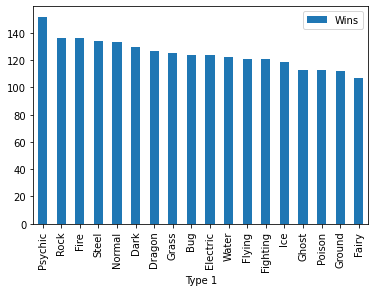

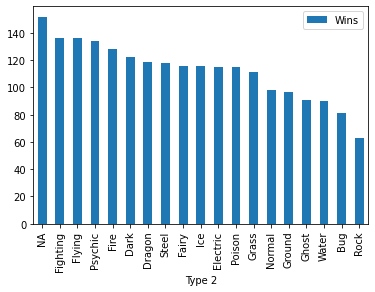

In [13]:
type_1 = pokemon[['Type 1','Wins']].groupby(['Type 1'], as_index=False).max().set_index('Type 1')
type_1.sort_values(by='Wins',ascending=False).plot(kind='bar')

type_2 = pokemon[['Type 2','Wins']].groupby(['Type 2'], as_index=False).max().set_index('Type 2')
type_2.sort_values(by='Wins',ascending=False).plot(kind='bar')

<BarContainer object of 20 artists>

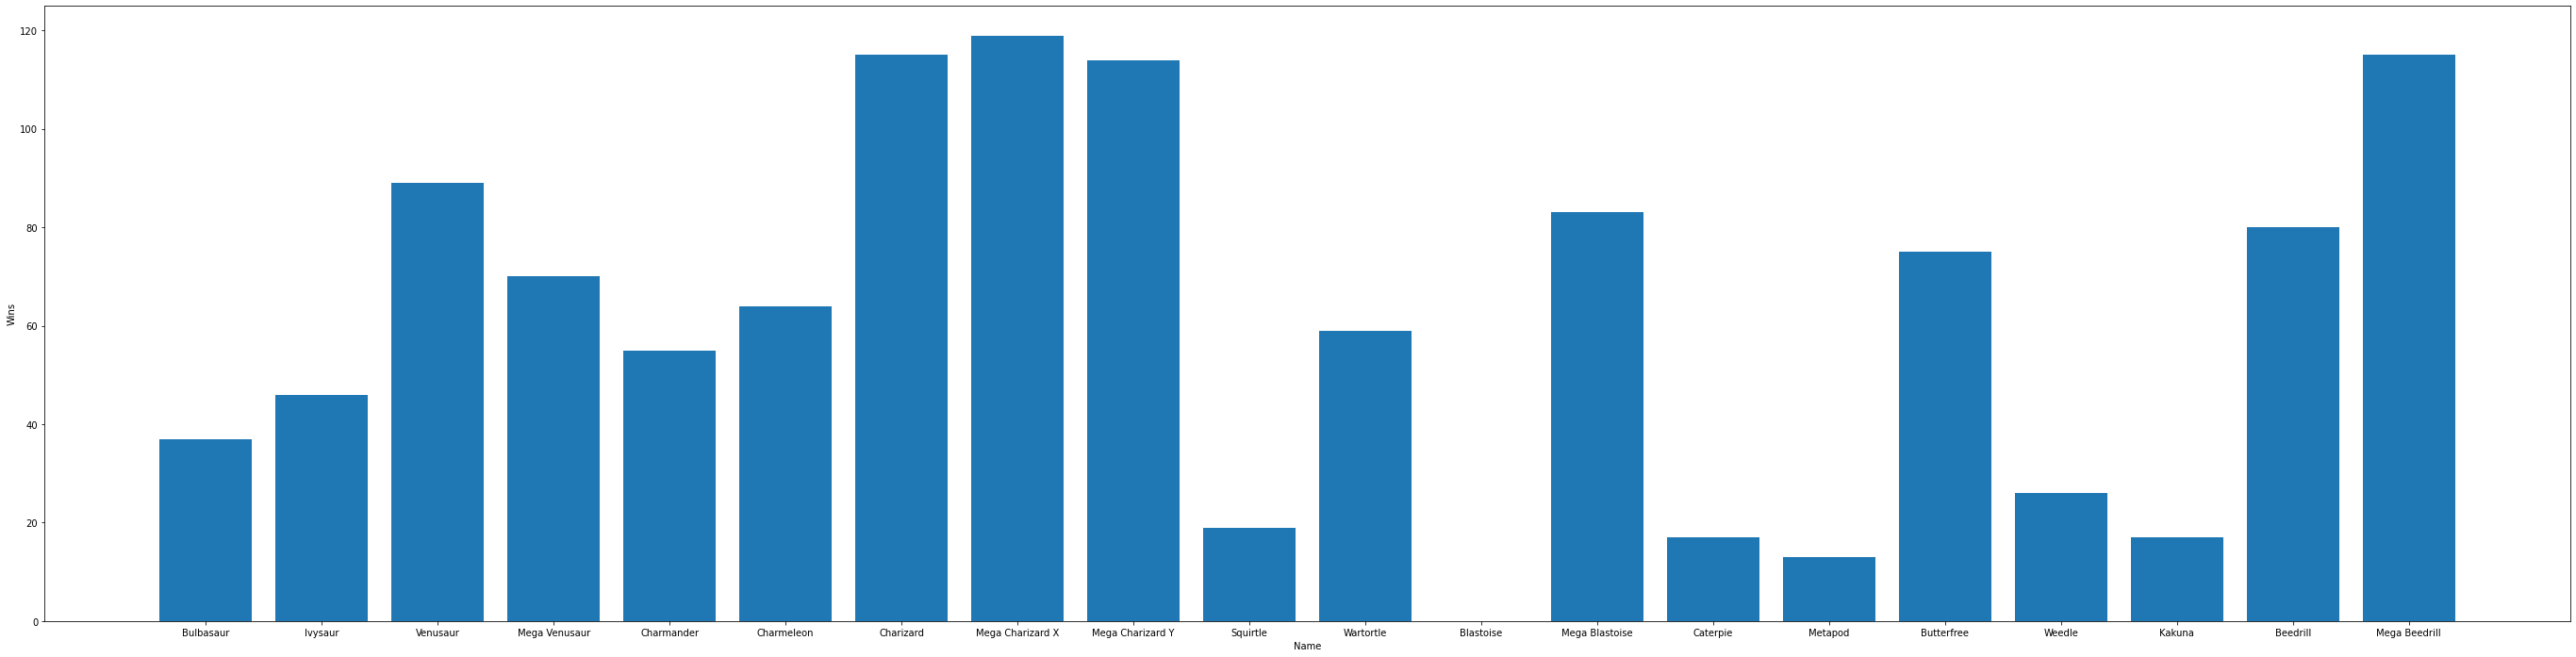

In [14]:
plt.figure(figsize=(48, 12))
plt.xlabel("Name")
plt.ylabel("Wins")
plt.bar(pokemon['Name'][:20], pokemon['Wins'][:20])

Text(0, 0.5, 'Wins')

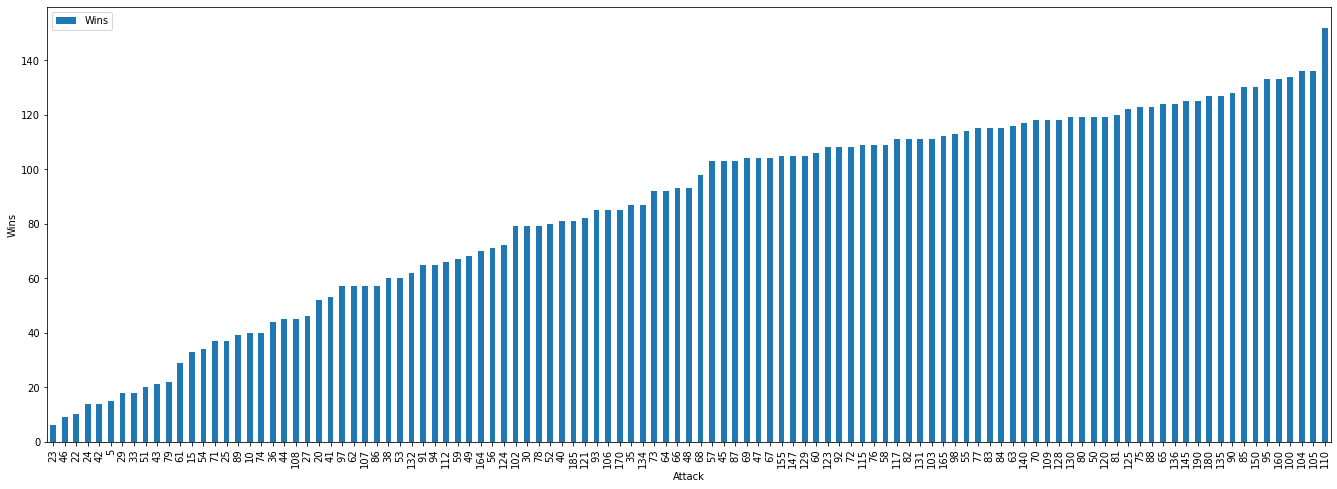

In [15]:

type_1 = pokemon[['Attack','Wins']].groupby(['Attack'], as_index=False).max().set_index('Attack')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar', figsize=(23,8)).set_ylabel("Wins")
#Number of wins is directly proportional too attack damage

<AxesSubplot:xlabel='Speed'>

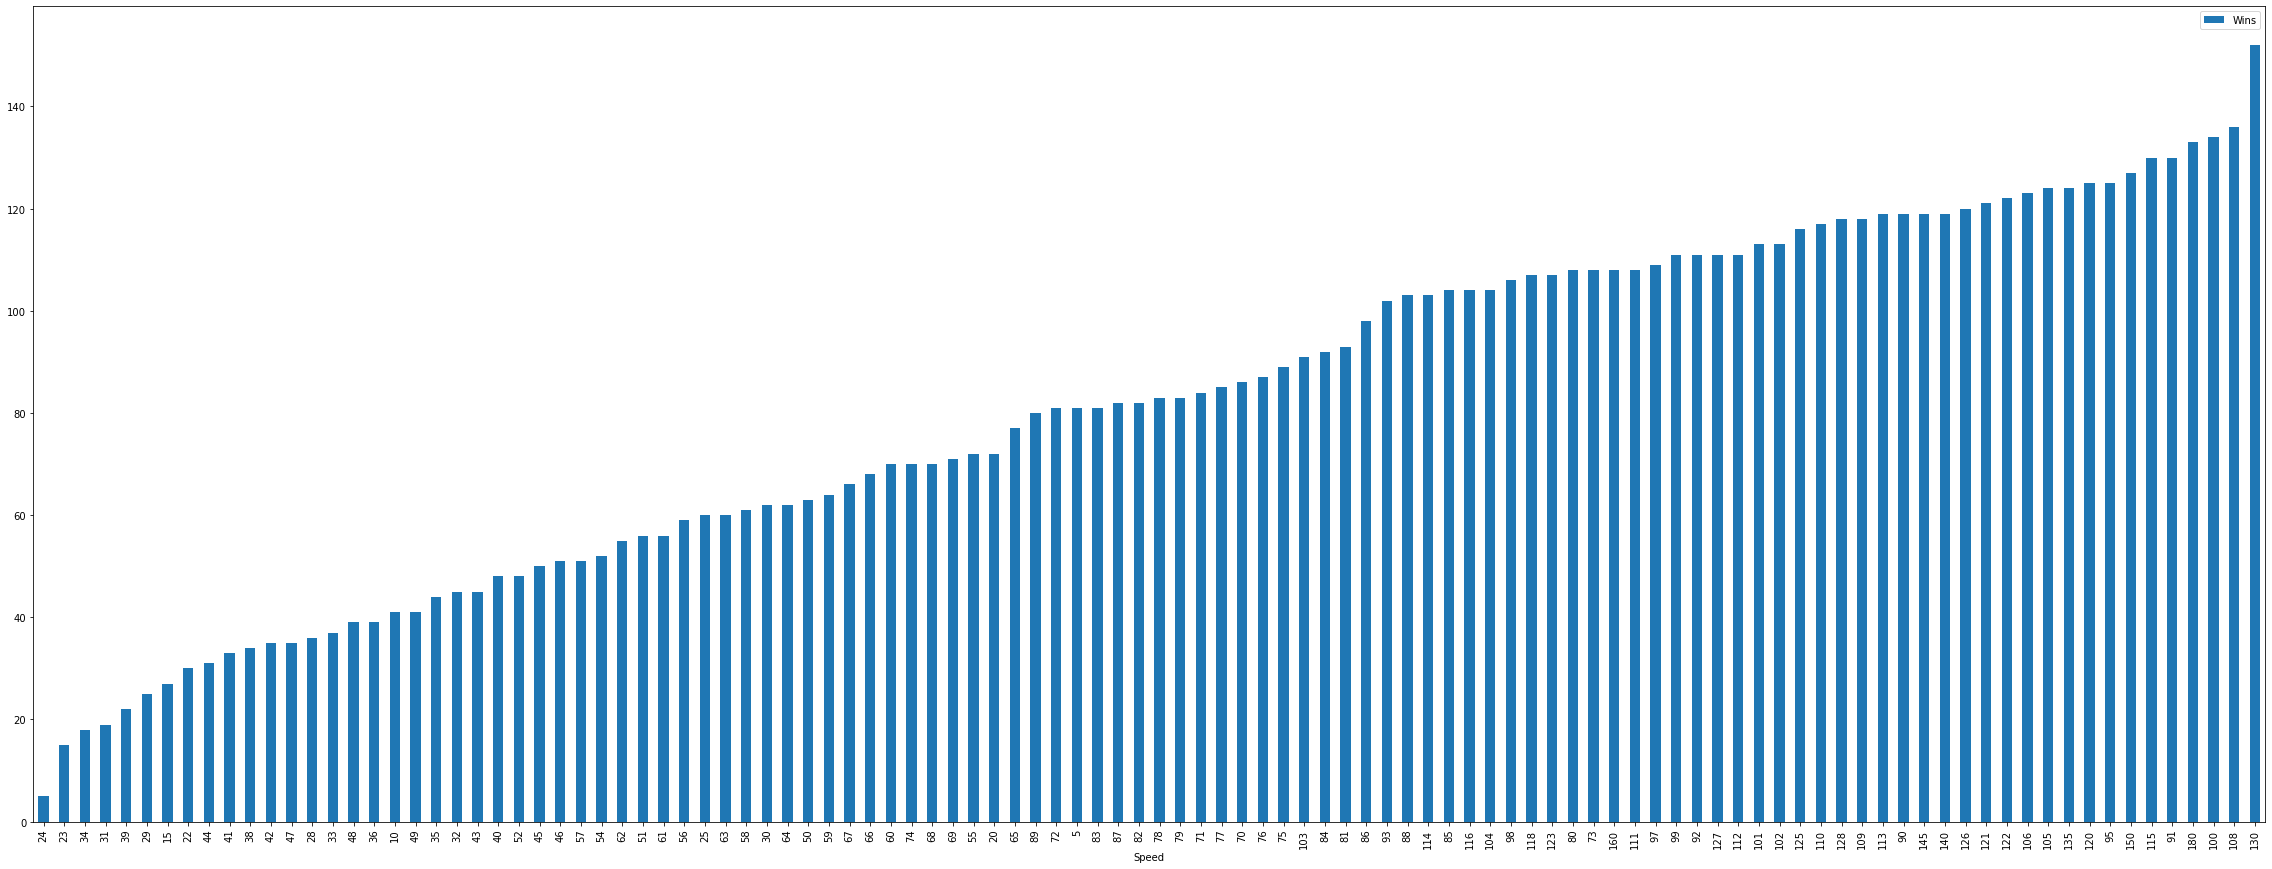

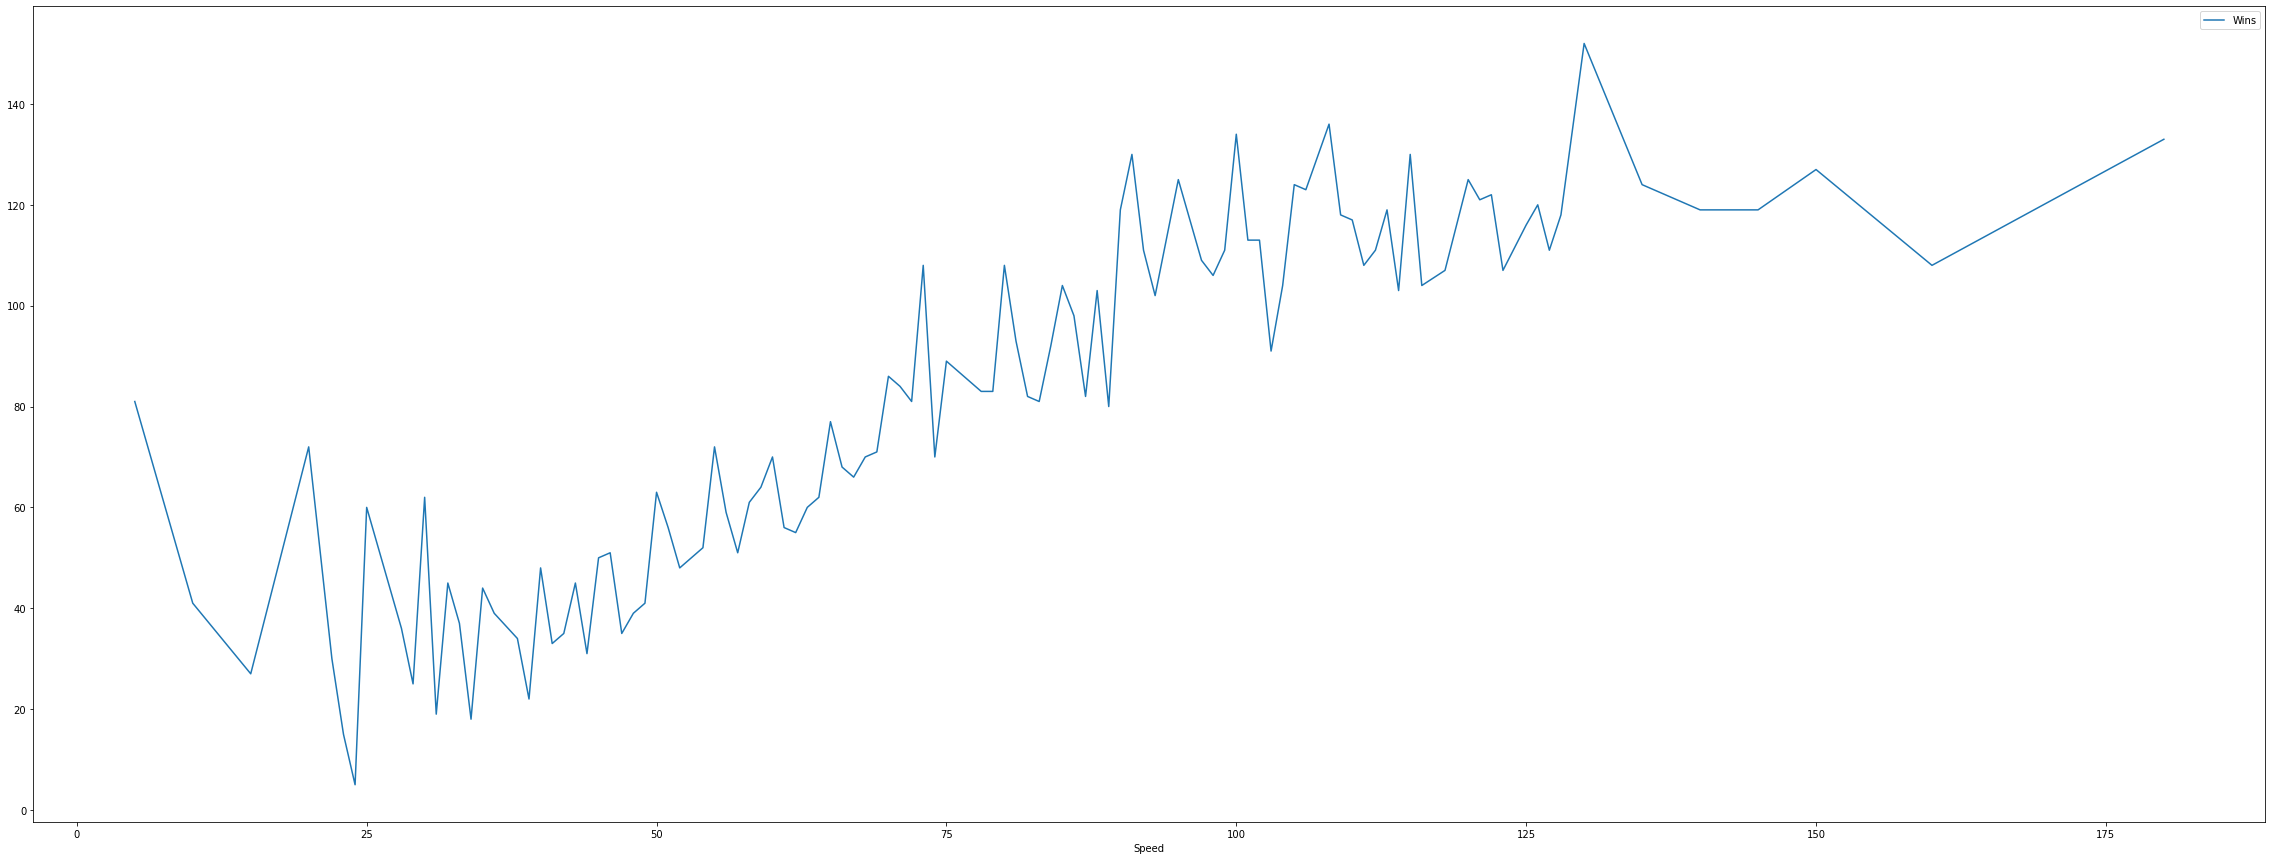

In [16]:
type_1 = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar', figsize=(40,15))
#Number of wins is directly proportional too Speed
type_1 = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
type_1.sort_values(by='Speed',ascending=True).plot(kind='line', figsize=(40,15))
#Number of wins is directly proportional too Speed

# Classifier Results Not Having in Account Types
As we know types take an important role in pokemon battles, for example a electric pokemon deals 2 times more damage to an water pokemon than to a fire pokemon and to times less damage to a rock pokemon, this interactions might prove challenging to some classification algorithms.

# Second approach

In [17]:
data_pd_frame = pd.DataFrame(data_diff_base_stats, columns=["HP Diff", "Attack Diff", "Defens Diff", "Sp. Atk diff", "Sp. Def dif", "Speed diff", "Win" ])
for column in data_pd_frame.columns:
    data_pd_frame[column] = data_pd_frame[column].astype(int)

In [18]:
data_pd_frame.dtypes

HP Diff         int64
Attack Diff     int64
Defens Diff     int64
Sp. Atk diff    int64
Sp. Def dif     int64
Speed diff      int64
Win             int64
dtype: object

In [19]:
X_diff_stats = data_pd_frame.drop(columns=["Win"]).values

X_diff_train, X_diff_test, y_train, y_test = train_test_split(X_diff_stats , y, test_size=0.25, random_state=42)

In [20]:
# Logistic Regression 
clf = LogisticRegression(max_iter=10000)
clf.fit(X_diff_train, y_train)
y_pred_log_reg = clf.predict(X_diff_test)
acc_log_reg = round( clf.score(X_diff_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')

88.41 percent


In [21]:
pd.DataFrame(zip(data_pd_frame.columns, np.transpose(clf.coef_[0])), columns=['features', 'coef']) 

,features,coef
0,HP Diff,-0.000941
1,Attack Diff,-0.009897
2,Defens Diff,-0.003292
3,Sp. Atk diff,0.002448
4,Sp. Def dif,-0.001284
5,Speed diff,-0.061518


Accuracy : 0.9496402877697842
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       574
           1       0.96      0.95      0.95       677

    accuracy                           0.95      1251
   macro avg       0.95      0.95      0.95      1251
weighted avg       0.95      0.95      0.95      1251



<AxesSubplot:>

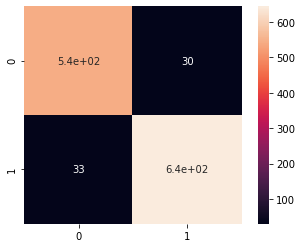

In [24]:
# Random Forest Classifier difference between most imp features
# Every diff
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_diff_train,y_train)
pred = model.predict(X_diff_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

In [26]:

X_Most_Imp_Features = data_pd_frame.drop(columns=["HP Diff", "Sp. Atk diff", "Sp. Def dif"])
X_train, X_test, y_train, y_test = train_test_split(X_Most_Imp_Features, y, test_size=0.25, random_state=42)
randomFlorestclf = RandomForestClassifier(n_estimators=100)
model = randomFlorestclf.fit(X_train,y_train)
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

Accuracy : 0.9480415667466027
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       574
           1       0.95      0.95      0.95       677

    accuracy                           0.95      1251
   macro avg       0.95      0.95      0.95      1251
weighted avg       0.95      0.95      0.95      1251



In [27]:
# Logistic Regression difference between most imp features
# Attack Diff Speed Dif
clf = LogisticRegression(C=100,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')

88.73 percent


# First approach

Pokemon stats in the same row types features encoded as a mapping

In [28]:
data = data_with_types.drop(columns=["Win", "Legendary", "Generation"]).values

76.82 percent


<AxesSubplot:>

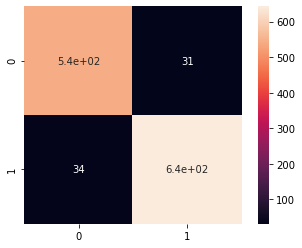

In [29]:
X = data[:, :-1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

In [30]:
data[:3,:]

array([[  7,   2,  50,  64,  50,  45,  50,  41,   6,  13,  70,  70,  40,
         60,  40,  60],
       [  6,   1,  91,  90,  72,  90, 129, 108,   7,   1,  91, 129,  90,
         72,  90, 108],
       [ 16,  11,  55,  40,  85,  80, 105,  40,  14,   0,  75,  75,  75,
        125,  95,  40]], dtype=int32)

Accuracy : 0.7969624300559552
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       574
           1       0.82      0.81      0.81       677

    accuracy                           0.80      1251
   macro avg       0.80      0.80      0.80      1251
weighted avg       0.80      0.80      0.80      1251

Accuracy : 0.7969624300559552
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       574
           1       0.82      0.81      0.81       677

    accuracy                           0.80      1251
   macro avg       0.80      0.80      0.80      1251
weighted avg       0.80      0.80      0.80      1251



<AxesSubplot:>

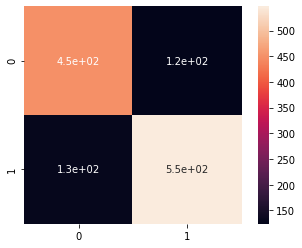

In [31]:
# Random Forest Classifier difference between most imp features
# Attack Diff Speed Dif
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

Accuracy : 0.6994404476418865
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       574
           1       0.73      0.70      0.72       677

    accuracy                           0.70      1251
   macro avg       0.70      0.70      0.70      1251
weighted avg       0.70      0.70      0.70      1251



/opt/anaconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<AxesSubplot:>

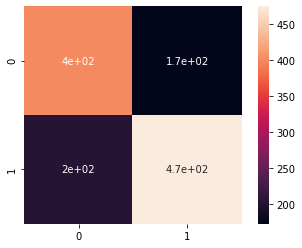

In [32]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, X.shape[1]), random_state=1, max_iter=100000)
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)


# Second Approach but using one hot encoding

not very good too many features too much time decay on accuracy

In [33]:
# limit to categorical data using df.select_dtypes()
data_one_hot_encoding = pd.DataFrame( data_one_hot_encoding,columns=['Type 1', 'Type 2', 'HP', 'Attack',
                                                   'Defense', 'Sp. Atk','Sp. Def', 'Speed',
                                                   'Generation', 'Legendary', 'Type 1', 'Type 2',
                                                   'HP', 'Attack',
                                                   'Defense', 'Sp. Atk','Sp. Def', 'Speed',
                                                   'Generation', 'Legendary', 'Winner'] )
save = data_one_hot_encoding.copy()

data_one_hot_encoding = data_one_hot_encoding.astype({'HP' : 'int32', 'Attack': 'int32',
                                                      'Defense': 'int32','Sp. Atk': 'int32',
                                                      'Sp. Def' : 'int32','Speed' : 'int32',
                                                      'Generation': 'int32', 'Legendary': 'int32', 'Winner': 'int32'})
print(data_one_hot_encoding.dtypes)
X_objects = data_one_hot_encoding.select_dtypes(include=[object])
X_objects.head(3)

Type 1        object
Type 2        object
HP             int32
Attack         int32
Defense        int32
Sp. Atk        int32
Sp. Def        int32
Speed          int32
Generation     int32
Legendary      int32
Type 1        object
Type 2        object
HP             int32
Attack         int32
Defense        int32
Sp. Atk        int32
Sp. Def        int32
Speed          int32
Generation     int32
Legendary      int32
Winner         int32
dtype: object


,Type 1,Type 2,Type 1,Type 2
0,Rock,Ground,Grass,Dark
1,Grass,Fighting,Rock,Fighting
2,Fairy,Flying,Psychic,NA


In [34]:

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_objects_fitted = X_objects.apply(le.fit_transform)
X_objects_fitted.head()

# limit to categorical data using df.select_dtypes()
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(X_objects_fitted)

# 3. Transform
onehotlabels = enc.transform(X_objects_fitted).toarray()
onehotlabels.shape
panda_Hot = pd.DataFrame(onehotlabels)
X_data_one_Hot = data_one_hot_encoding.drop(columns=["Winner", "Type 1", "Type 2"])

X_data_one_Hot = X_data_one_Hot.join(panda_Hot)
X_data_one_Hot.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,HP,Attack,...,64,65,66,67,68,69,70,71,72,73
0,50,64,50,45,50,41,2,0,70,70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,91,90,72,90,129,108,5,1,91,129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55,40,85,80,105,40,2,0,75,75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,40,40,70,40,20,2,0,77,120,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70,60,125,115,70,55,1,0,20,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_data_one_Hot, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3750, 90)
(3750,)


In [36]:
#this is bad3!
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, X_data_one_Hot.shape[1]), random_state=1, max_iter=100000000)

y = data_one_hot_encoding.Winner
print(y.shape)

model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print(set(pred))
print(set(y_test))
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

(5001,)
{0, 1}
{0, 1}
Accuracy : 0.9072741806554756
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       574
           1       0.90      0.93      0.92       677

    accuracy                           0.91      1251
   macro avg       0.91      0.91      0.91      1251
weighted avg       0.91      0.91      0.91      1251



Accuracy : 0.8840927258193445
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       574
           1       0.89      0.89      0.89       677

    accuracy                           0.88      1251
   macro avg       0.88      0.88      0.88      1251
weighted avg       0.88      0.88      0.88      1251



<AxesSubplot:>

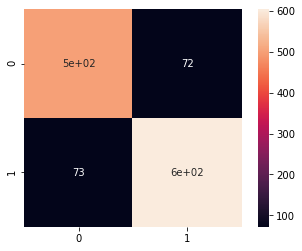

In [37]:
# Random Forest Classifier difference between most imp features
# Attack Diff Speed Dif
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)

pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

88.33 percent


<AxesSubplot:>

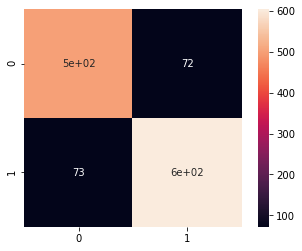

In [38]:
clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

# Third Approach

Use only attack speed and types as a map

In [39]:
X = data_with_types[["Type 1", "Type 2", "Attack", "Speed"]]
X.head(3)

,Type 1,Type 1,Type 2,Type 2,Attack,Attack,Speed,Speed
0,7,6,2,13,64,70,41,60
1,6,7,1,1,90,129,108,108
2,16,14,11,0,40,75,40,40


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_data_one_Hot, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3750, 90)
(3750,)


In [41]:
#this is bad3!
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, X_data_one_Hot.shape[1]), random_state=1, max_iter=100000000)

y = data_one_hot_encoding.Winner
print(y.shape)

model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print(set(pred))
print(set(y_test))
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

(5001,)
{0, 1}
{0, 1}
Accuracy : 0.9072741806554756
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       574
           1       0.90      0.93      0.92       677

    accuracy                           0.91      1251
   macro avg       0.91      0.91      0.91      1251
weighted avg       0.91      0.91      0.91      1251



Accuracy : 0.8721023181454837
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       574
           1       0.89      0.88      0.88       677

    accuracy                           0.87      1251
   macro avg       0.87      0.87      0.87      1251
weighted avg       0.87      0.87      0.87      1251



<AxesSubplot:>

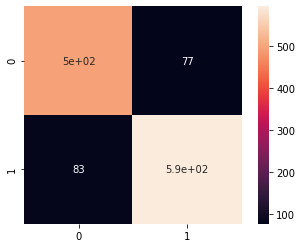

In [42]:
# Random Forest Classifier difference between most imp features
# Attack Diff Speed Dif
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)

pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

88.33 percent


<AxesSubplot:>

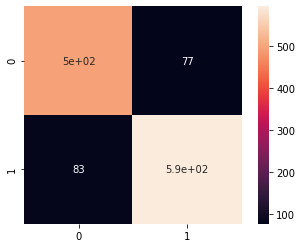

In [43]:

clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)